In [2]:
from scvi.distributions import NegativeBinomial, Poisson, ZeroInflatedNegativeBinomial

Global seed set to 0
/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [3]:
gene_likelihood = "nb"

In [4]:
# px_r = torch.exp(px_r)

In [24]:
LIBRARY_SIZE = 1e5

px_rate, px_r, px_dropout = (10, 1, 0.1)
px_scale = px_rate / LIBRARY_SIZE

In [50]:
if gene_likelihood == "zinb":
    px = ZeroInflatedNegativeBinomial(
        mu=px_rate,
        theta=px_r,
        zi_logits=px_dropout,
        scale=px_scale,
    )
elif gene_likelihood == "nb":
    px = NegativeBinomial(mu=px_rate, theta=px_r, scale=px_scale)
elif gene_likelihood == "poisson":
    px = Poisson(px_rate, scale=px_scale)

In [20]:
import matplotlib.pyplot as plt
import numpy as np

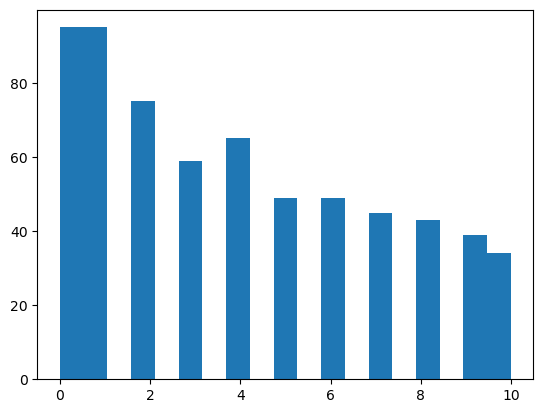

In [21]:
plt.hist(px.sample((1000,)).numpy(), bins=np.linspace(0, 10, 20));

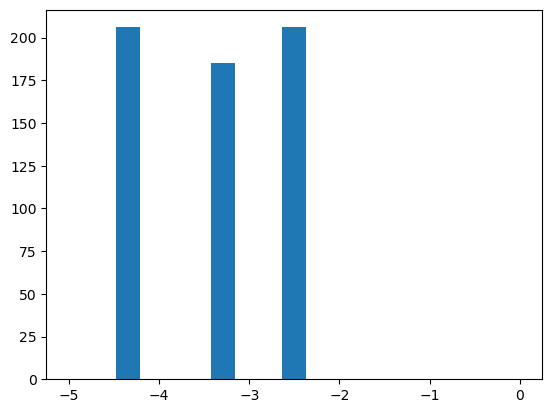

In [22]:
import torch

plt.hist(px.log_prob(10 * torch.randint(5, (1000,))), bins=np.linspace(-5, 0, 20));

In [23]:
LIBRARY_SIZE = 1e5

In [25]:
from scvi.nn import DecoderSCVI

In [26]:
decoder = DecoderSCVI(100, 10)

In [48]:
x = torch.rand((100, 100))
px_scale, px_r, px_rate, px_dropout = decoder.forward('gene-cell', x, torch.scalar_tensor(LIBRARY_SIZE))

In [49]:
px_scale.shape

torch.Size([100, 10])

In [61]:
px._validate_sample(torch.asarray([-1]))

ValueError: Expected value argument (Tensor of shape (1,)) to be within the support (IntegerGreaterThan(lower_bound=0)) of the distribution NegativeBinomial(mu: torch.Size([100, 10]), theta: torch.Size([100, 10])), but found invalid values:
tensor([-1])

In [1]:
import anndata as ad
from scvi.model import SCVI


TABULA_SAPIENS_BY_CELL_TYPE_WITH_EMBEDS_PT = "/Users/nsofroniew/Documents/data/multiomics/cell_census/tabula_sapiens_by_features_with_embeds_new_norm.h5ad"
TABULA_SAPIENS_BY_CELL_TYPE_SCVI_MODEL = "/Users/nsofroniew/Documents/data/multiomics/cell_census/tabula_sapiens_by_features_scvi_model_new_norm/"

adata = ad.read_h5ad(TABULA_SAPIENS_BY_CELL_TYPE_WITH_EMBEDS_PT)

train_cells = adata.obs["train"]
adata_train = adata[train_cells].copy()

SCVI.setup_anndata(adata_train, layer="counts")

# model = SCVI(adata_train, n_layers=4, n_hidden=512, n_latent=64)
# model = SCVI(adata_train, n_layers=2, n_hidden=256, n_latent=32, dispersion='gene-cell')
model = SCVI(
    adata_train,
    n_layers=2,
    n_hidden=256,
    n_latent=32,
    dispersion="gene",
    gene_likelihood="zinb",
)

Global seed set to 0
/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)
/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:91: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this i

In [7]:
import torch.nn as nn

In [8]:
model.module.decoder.px_scale_decoder[1] = nn.Softplus()